# Customer segmentation (clustering)
## Bank client data
### This notebook uses the *bank-additional-full_miss.csv* dataset

This notebook is an example. It does not show an exhaustive detail on all CRISP-DM phases.

(c) Nuno António 2020-2022 - Rev. 2.03

### Dataset description

Dataset related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed.

#### bank client data:
- **age**: numeric - age of the customer
- **job**: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- **marital**: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- **education**: (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- **default**: has credit in default? (categorical: 'no','yes','unknown')
- **housing**: has housing loan? (categorical: 'no','yes','unknown')
- **loan**: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
- **contact**: contact communication type (categorical: 'cellular','telephone') 
- **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- **day_of_week**: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client (numeric)
- **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes
- **emp.var.rate**: employment variation rate - quarterly indicator (numeric)
- **cons.price.idx**: consumer price index - monthly indicator (numeric) 
- **cons.conf.idx**: consumer confidence index - monthly indicator (numeric) 
- **euribor3m**: euribor 3 month rate - daily indicator (numeric)
- **nr.employed**: number of employees - quarterly indicator (numeric)

#### subscrition info
- **y**: has the client subscribed a term deposit? (binary: 'yes','no')



More information on the dataset available at https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## Initial setup and modules/packages loading

In [2]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
# import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

In [3]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [4]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

plots_barTexts_fontSize = 8

## Data understanding

In [5]:
# Load data 
ds = pd.read_csv('/kaggle/input/wali-3/Case1_HotelCustomerSegmentation.csv', sep=";")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111733 entries, 0 to 111732
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    111733 non-null  int64  
 1   Nationality           111733 non-null  object 
 2   Age                   107561 non-null  float64
 3   DaysSinceCreation     111733 non-null  int64  
 4   NameHash              111733 non-null  object 
 5   DocIDHash             110732 non-null  object 
 6   AverageLeadTime       111733 non-null  int64  
 7   LodgingRevenue        111733 non-null  float64
 8   OtherRevenue          111733 non-null  float64
 9   BookingsCanceled      111733 non-null  int64  
 10  BookingsNoShowed      111733 non-null  int64  
 11  BookingsCheckedIn     111733 non-null  int64  
 12  PersonsNights         111733 non-null  int64  
 13  RoomNights            111733 non-null  int64  
 14  DistributionChannel   111733 non-null  object 
 15  

In [6]:
# Display top 5 rows
ds.head(5)

,ID,Nationality,Age,DaysSinceCreation,NameHash,DocIDHash,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,...,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,1,PRT,52.0,440,0x2C371FD6CE12936774A139FD7430C624F1C4D5109CE6...,0x434FD3D59469C73AFEA087017FAF8CA2296493AEABDE...,59,292.0,82.3,1,...,0,0,0,0,0,0,0,0,0,0
1,2,PRT,NaN,1385,0x198CDB98BF37B6E23F9548C56A88B00912D65A9AA0D6...,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,61,280.0,53.0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,DEU,32.0,1385,0xDA46E62F66936284DF2844EC4FC542D0DAD780C0EE0C...,0x27F5DF762CCDA622C752CCDA45794923BED9F1B66300...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,FRA,61.0,1385,0xC45D4CD22C58FDC5FD0F95315F6EFA5A6E7149187D49...,0x8E59572913BB9B1E6CAA12FA2C8B7BF387B1D1F3432E...,93,240.0,60.0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,FRA,52.0,1385,0xD2E3D5BFCA141865669F98D64CDA85AD04DEFF47F8A0...,0x42BDEE0E05A9441C94147076EDDCC47E604DA5447DD4...,0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,111733.0,NaN,NaN,NaN,55867.0,32254.683151,1.0,27934.0,55867.0,83800.0,111733.0
Nationality,111733,199,FRA,16516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,107561.0,NaN,NaN,NaN,45.639191,17.244952,-10.0,33.0,47.0,58.0,123.0
DaysSinceCreation,111733.0,NaN,NaN,NaN,595.026599,374.657382,36.0,288.0,522.0,889.0,1385.0
NameHash,111733,107584,0x15A713CE687991691A18F6CDC56ABE24979C73CF5D51...,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DocIDHash,110732,103480,0xE3B0C44298FC1C149AFBF4C8996FB92427AE41E4649B...,3032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AverageLeadTime,111733.0,NaN,NaN,NaN,60.833147,85.11532,-1.0,0.0,21.0,95.0,588.0
LodgingRevenue,111733.0,NaN,NaN,NaN,283.851283,379.131556,0.0,0.0,208.0,393.3,21781.0
OtherRevenue,111733.0,NaN,NaN,NaN,64.682802,123.580715,0.0,0.0,31.0,84.0,8859.25
BookingsCanceled,111733.0,NaN,NaN,NaN,0.002282,0.080631,0.0,0.0,0.0,0.0,15.0


In [8]:
# Check counts of categorical variables
cols = ['default', 'housing', 'loan', 'poutcome' , 'y']
ds[cols].apply(pd.Series.value_counts)

KeyError: "None of [Index(['default', 'housing', 'loan', 'poutcome', 'y'], dtype='object')] are in the [columns]"

In [9]:
# Check missing values
print(ds.isnull().sum())

ID                         0
Nationality                0
Age                     4172
DaysSinceCreation          0
NameHash                   0
DocIDHash               1001
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64


Summary statistics shows:
- Duration and campaing present missing values. Other columns present no missing values (in the sense of having no empty columns). But, some binary columns wih yes and no categories, show that there are a third category, so missing values could be in that third category (e.g., **default**, **housing**, etc.).
- **Job** has 12 categories. This can indicate issues in distribution, such as some categories win many observations and others with only a few observations. **Marital** and **Education** also have a high number of categories. 

In [10]:
# Exploration of categorical variables: cross table of job and education
table1 = pd.crosstab(index=ds['Age'], columns=ds['DocIDHash'])
table1

DocIDHash,0x00006E606D590F336C289D2CC995A0C726878BCAC001496A96243F0CA824A429,0x0000E25BC06E730F6DDD6BD53CBFE05BABD2B0182019DEC4C9CA16AABE1B2A76,0x0001425DE03D204F30757BA2E50DBD0486ED254E1E6FC9E1EA5E647EBD2109FE,0x0002AE77553DBEBD734F0C644E6BE142EA0B4C5D5D83417D6E3C5B3211F7F4B9,0x0002DDD31332B77DA9499876CD3577B08844812E95F26943D88D5123E9FCB585,0x0002DE82570CC9C1FCB011BB15EA98B1004D32F55DCE597E658463F215F9D401,0x0002ED07243C5575B6A6FBD42EF80DE8006E0CFDC21CA8753DD5B2F14CDCBEB8,0x000394A95AC0BF307557B6BEFBE3F9442BD500BA48B4706FAFF3C145B85FBE94,0x000443891856CB5D74287EDBFBE82A4F6D2841F2D1DBD7C9E4768049339A7B93,0x0004C8DCE2B4B50CB6872BFE50E79528C3BA71DA0A3B25BF72CD18B697799D64,...,0xFFF819C6E188C481DC278CCD890F1A13238653852E2F792CD1802557F3FF08F4,0xFFF83A2F6373428A48883E0CC59DB0239471AE3CCE9F054449B17810950ECDCF,0xFFFAD5D0530C235C066711420BB117EE6C2E04E4DE1FFF62CE3420F78D4F4523,0xFFFAF284C2B6E97FEA54FBFFC5C6D8E1F51C5F7F0714A5186AA06192D896BC23,0xFFFB00CE2F3F640FAE90A8BF4965B721FE0DC1C7183DF6102281A645FF1D64DD,0xFFFB1DBFAB9D8FFDC8602C6D365578FBFF637070F3EB762A6BD1FC92221A3C59,0xFFFB9FE60E0D35B8426F2FB90646D0BA799B803A79C14CCDD1E3CDFBC9CF65BE,0xFFFE14C4D0D6520C97125A115CDC705B8A2F0E5133D5C0735B0EA9EDE19B95FD,0xFFFED0F2BC7D4A410C579CEE04804A70F09C1B21B34076056BA28B97B315013F,0xFFFF697C455DCDFA906747736B03F3A61D20A92C8F741ED432C03B2E7E5DD6AD
Age,,,,,,,,,,,,,,,,,,,,,
-10.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-8.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-6.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-5.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
111.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
114.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Visual exploration of the cross table

# Draw
fig, ax = plt.subplots(figsize=(8,5))
ds.plot(kind="bar", 
            ax=ax,
            stacked=True)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Job vs Education counts", fontsize=plots_Title_fontSize)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.rc('axes', labelsize=subPlots_label_fontSize)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='lower center', 
          ncol=4, bbox_to_anchor=(0.45, -0.5), frameon=False)

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x78f1c0a02c20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x78f1c0a01f30> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/tmp/ipykernel_34/562761278.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds[x] , bins = 15)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


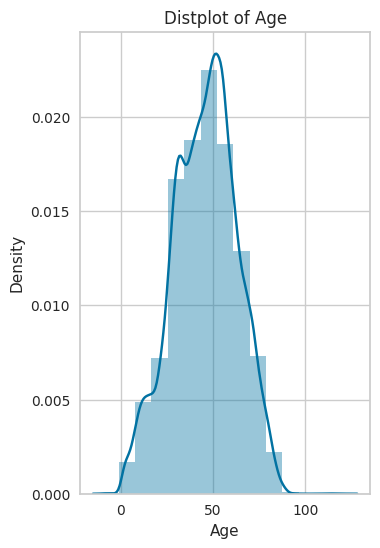

In [14]:
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Age']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.distplot(ds[x] , bins = 15)
    plt.title('Distplot of {}'.format(x))
plt.show()

In [ ]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);

In [ ]:
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize);

In [ ]:
# CORRELATION 

# Create correlation matrix
corr = ds[numerical].corr(method='spearman')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# Draw
fig , ax = plt.subplots(figsize=(8, 10))
heatmap = sns.heatmap(corr,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      fmt='.4f',
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': heatmaps_text_fontSize})

# Decoration
plt.title("Spearman correlation between numeric variables", fontsize=plots_Title_fontSize)
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns, rotation = 45)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

## Data preparation

In [ ]:
# Create a modeling dataset from the original dataset
X = ds.copy(deep=True)

In [ ]:
# Treat the missing values in Duration and Campaign columns (just to illustrate as these columns will not be used in modelling)
# For more information check https://scikit-learn.org/stable/modules/impute.html 

# Duration - imputation with the median
imp = SimpleImputer(missing_values=np.nan, strategy='median')
X['duration'] = imp.fit_transform(X['duration'].values.reshape(-1,1))[:,0]

# Campaign - imputation with the most frequent
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X['campaign'] = imp.fit_transform(X['campaign'].values.reshape(-1,1))[:,0]

# Since the number of missing rows is so small we could have removed the rows using .dropna
# For more information see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

In [ ]:
# Bin the age
X['age_bins'] = pd.cut(x=X['age'], bins=[0, 19, 29, 39, 49, 59, 99], labels=['<20','20-29','30-39','40-49','50-59','>=60'])

# Drop the age column
X.drop(columns='age', inplace=True)

In [ ]:
# Remove columns that should not be used as they do not represent customer's characteristics or behavior
cols = ['contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
X.drop(columns=cols, inplace=True)

In [ ]:
# K-Means requires all features to be numeric
# Encode target to 0 (no) and 1 (yes)
X['y'] = X['y'].map({'yes': 1, 'no': 0})

In [ ]:
# Encode categorical variables to dummy variables
# For more information the different methods to enconde categorical variables check https://contrib.scikit-learn.org/category_encoders/
cols = ['default', 'housing', 'loan', 'poutcome', 'age_bins' ]
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [ ]:
def one_hot(s, threshold,prefix):
    """Do one-hot encoding for categories above a threshold and create a dummy column for all others named "Other"

    Args:
        s (series): series to apply the transformation
        threshold (numerical): threshold above which a dummy column should be created (from 0 to 1, corresponding from 0 to 100%)
        prefix (string): prefix to assign to the created columns

    Returns:
        dataframe: dataframe with the applied transformations 
    """
    # Check dummies for the column
    d = pd.get_dummies(s)

    # Check if percentage is below threshold and act accordingly
    f = pd.value_counts(s, sort=False, normalize=True) < threshold
    if f.sum() == 0:
        newSeries=d
    else:
        newSeries=d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('Other'))
    # Add the prefix and return the result    
    newSeries=newSeries.add_prefix(prefix)
    return newSeries

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

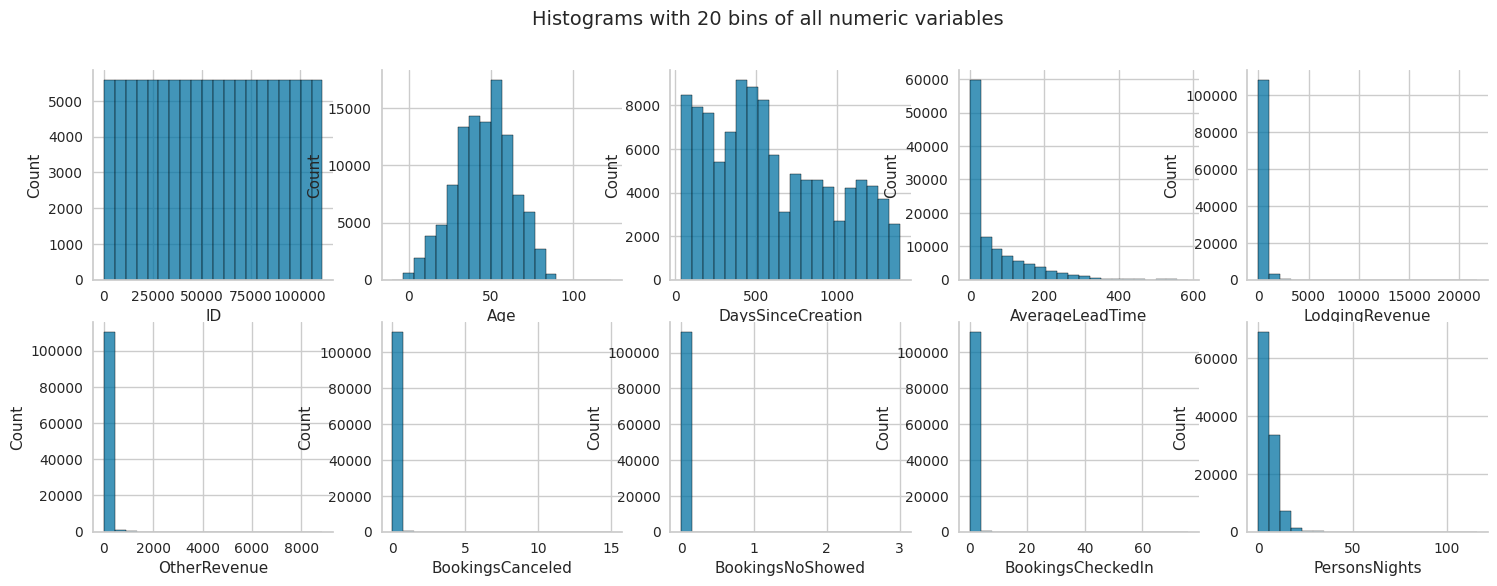

In [16]:
# HISTOGRAM (ALL NUMERIC VARIABLES)

# Identify all numeric variables in the dataset
numerical=ds.select_dtypes(include=[np.number]).columns.tolist()

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.histplot(data=ds,
                bins=20,
                 x=var,
                 ax=subplot,
                 kde=False)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Histograms with 20 bins of all numeric variables", fontsize=plots_Title_fontSize);

# Save to file
#fig.savefig(fname=exportsFolder+'MultipleHistogram.svg', bbox_inches="tight")


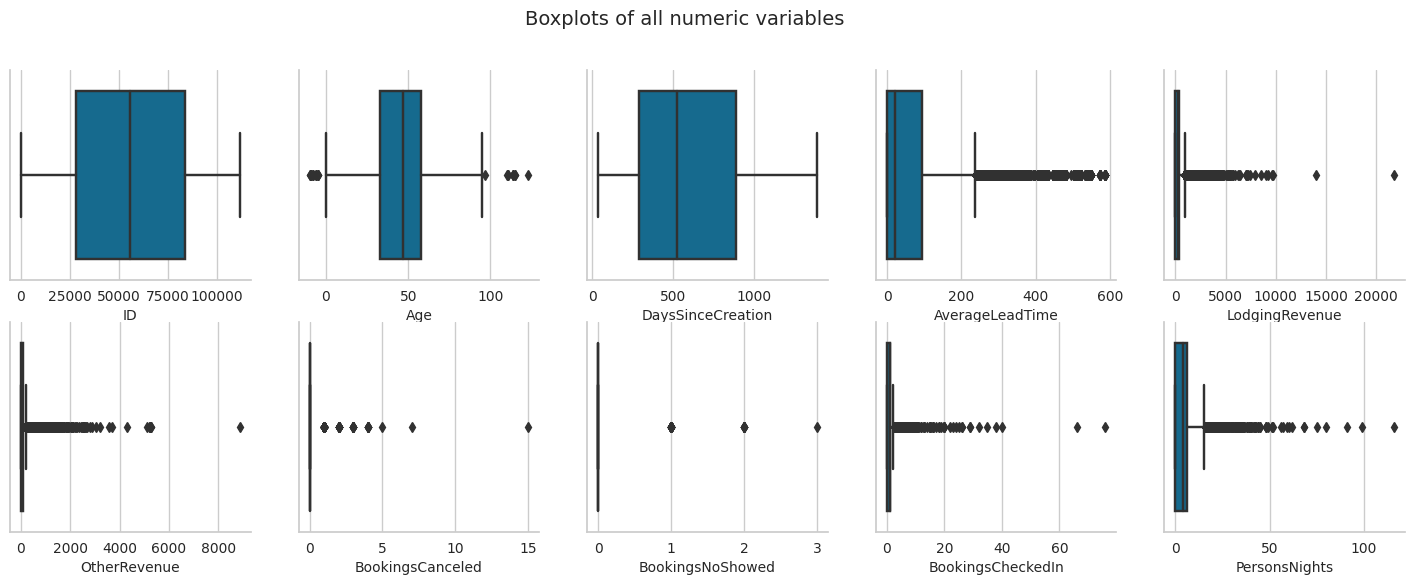

In [17]:
# BOXPLOT (ALL NUMERIC VARIABLES)

# Draw
fig, ax = plt.subplots(2, 5, figsize=(18,6))
for var, subplot in zip(ds[numerical], ax.flatten()):
    g = sns.boxplot(data=ds,
                 x=var,
                 ax=subplot)

# Decoration
sns.despine()
plt.rc('axes', labelsize=subPlots_label_fontSize)
fig.suptitle("Boxplots of all numeric variables", fontsize=plots_Title_fontSize);

# Save to file
#fig.savefig(fname=exportsFolder+'MultipleBoxplots.svg', bbox_inches="tight")

In [ ]:
# One hot encoding of all categories above 15% - all others categories to "Other"
cols = ['job', 'marital', 'education']
for i in range(len(cols)):
    colToProcess = X[cols[i]].astype(str)
    procDF = one_hot(colToProcess, .15,cols[i]+'_')
    X.drop(columns=cols[i], inplace=True)
    X = pd.concat([X, procDF], axis=1)

In [ ]:
# Get a copy of the dataframe before normalization for results' analysis
X_beforeNorm = X.copy(deep=True)

In [ ]:
# Normalize all columns
# MinMax scaler returns an array, so the dataframe must be recreated
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

In [ ]:
# Check dataframe structure and statistics after all transformations
print(X.shape)
X.describe(include='all').T

- The results transformation made the modeling dataset end up with 29 columns.
- All columns are now numeric, with values in the range of 0 to 1

### Analyze Principal Components

(41188, 2)


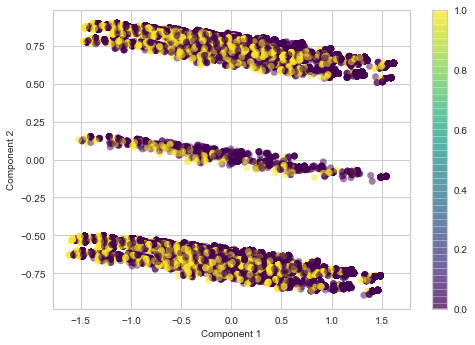

In [25]:
# Let's use PCA to visualize with only two components
pca2 = PCA(n_components = 2)
pca2.fit(X)
X_pca2 = pca2.transform(X)
print(X_pca2.shape)

# Scatter plot of the two Principal Components by the "target" to see if there is any pattern
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=X.y, edgecolor='none', alpha=0.5, cmap='viridis')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

The two main components visualization shows that there seems to exist three or six clusters. Three horizontal clusters, with some other separated clusters at the right.

In [26]:
# Fit the PCA algorithm to data 
pca = PCA().fit(X)

# Show the variance per component
pcaevr = ['{:f}'.format(item) for item in pca.explained_variance_ratio_]
pcaDF = pd.DataFrame({'Component': range(1, len(X.columns)+1),
                      'Variance explained': pcaevr,
                      'Cumulative variance explained': np.cumsum(pca.explained_variance_ratio_)})
pcaDF

,Component,Variance explained,Cumulative variance explained
0,1,0.146522,0.146522
1,2,0.118040,0.264562
2,3,0.094042,0.358604
3,4,0.082169,0.440773
4,5,0.074665,0.515438
5,6,0.069559,0.584997
6,7,0.063782,0.648779
7,8,0.061127,0.709906
8,9,0.048925,0.758831
9,10,0.046672,0.805502


Text(0.5, 1.0, 'Explained variance by components')

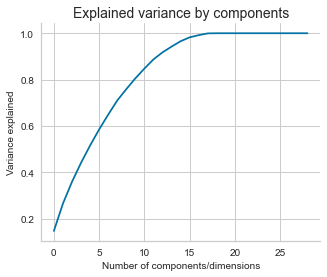

In [27]:
# Plot the cumulative explained variance

# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))

# Decoration
sns.despine()
plt.xlabel('Number of components/dimensions')
plt.ylabel('Variance explained')
plt.rc('axes', labelsize=subPlots_label_fontSize)
plt.title('Explained variance by components', fontsize=plots_Title_fontSize)

With 15 components is possible to explain 96.5% of the variance.

## Modeling - K-Means - 15 Components
For information about K-Means and other clustering algoritms available in Scikit-learn check https://scikit-learn.org/stable/modules/clustering.html

In [28]:
# Apply the dimension reduction to the dataset (for 15 components)
pca_reduced = PCA(n_components = 15)
pca_reduced.fit(X)
X_pca_reduced = pca_reduced.transform(X) 
print(X_pca_reduced.shape)

(41188, 15)


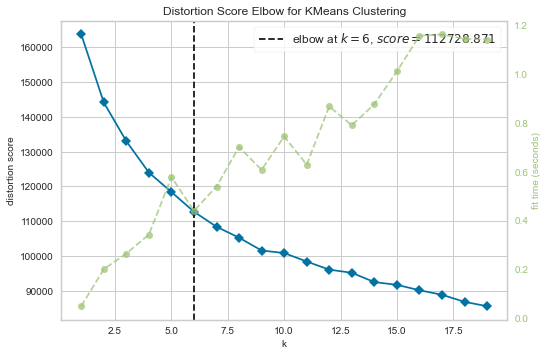

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Apply the Elbow method to select K
km = KMeans()
visualizer = KElbowVisualizer(km, k=(1,20), random_state=123)
visualizer.fit(X_pca_reduced)
visualizer.show() 

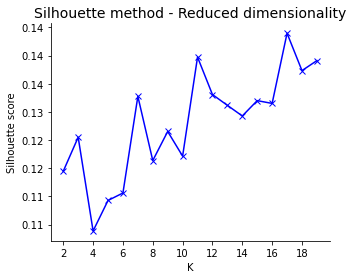

In [ ]:
# Select K based on the Silhouette method
# ATTENTION! Depending on the computer this can take long time to run (more than 10 minutes)
sil = []

# Dissimilarity can only be measured in more than 1 partition, therefore it starts on K=2
for k in range(2, 20):
  km = KMeans(n_clusters = k, random_state=123).fit(X)
  labels = km.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))


# Show Results
# Draw
fig , ax = plt.subplots(figsize=(5, 4))
plt.plot(range(2, 20), sil, 'bx-')
# Decoration
sns.despine()
fmt = "{x:,.2f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.rc('axes', labelsize=subPlots_label_fontSize)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.title('Silhouette method - Reduced dimensionality', fontsize=plots_Title_fontSize);

The Elbow method indicates K should be 6, but the Silhouette method points to higher values such 17. However, since large number of clusters are not very helpful for marketing pruposes, let's select K as 6

In [31]:
# Apply the K-Means for K=6
K=6
kmeans = KMeans(n_clusters=K, random_state=123)
allDistances = kmeans.fit_transform(X_pca_reduced)
y_kmeans = kmeans.predict(X_pca_reduced)

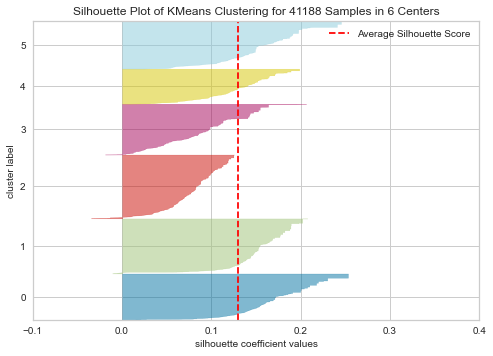

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 41188 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [32]:
# Visualize Silhouette - see https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X_pca_reduced)
visualizer.show()

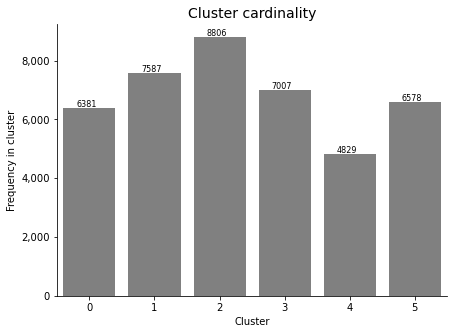

In [ ]:
# Plot clusters cardinality 

# Count observations per cluster
freqByCluster = X_beforeNorm.groupby(y_kmeans).size()

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.countplot(x=y_kmeans, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(freqByCluster):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster cardinality", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Frequency in cluster")
plt.rc('axes', labelsize=subPlots_label_fontSize)

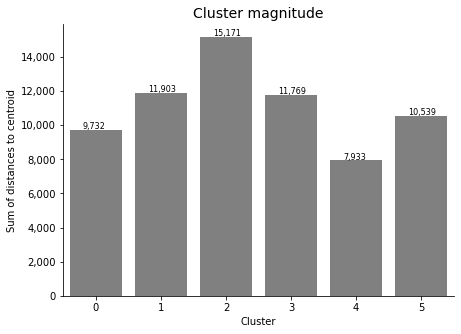

In [ ]:
# Plot clusters magnitude

# Compute Magnitude
X['distanceToCentroid'] = np.min(allDistances,axis=1)
magnitude = X['distanceToCentroid'].groupby(y_kmeans).sum()
X = X.drop(columns=['distanceToCentroid'])

# Draw
fig, ax = plt.subplots(figsize=(7,5))
g = sns.barplot(x=magnitude.index, y=magnitude.values, color='grey')

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
for index,data in enumerate(magnitude):
    plt.text(x=index-0.2 , y=data+50 , s=f"{data:,.0f}" , fontdict=dict(fontsize=plots_barTexts_fontSize))
sns.despine()
plt.title("Cluster magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cluster")
plt.ylabel("Sum of distances to centroid")
plt.rc('axes', labelsize=subPlots_label_fontSize)

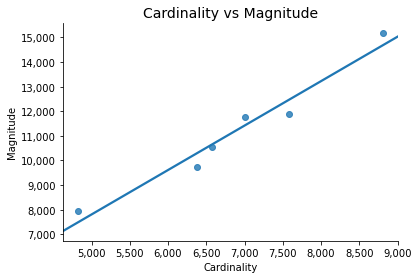

In [ ]:
# Plot cardinality vs magnitude

# Draw
fig, ax = plt.subplots(figsize=(6,4))
g = sns.regplot(x=freqByCluster, y=magnitude, scatter=True, seed=123,truncate=False, ci=None)

# Decoration
fmt = "{x:,.0f}"
tick = ticker.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
sns.despine()
plt.title("Cardinality vs Magnitude", fontsize=plots_Title_fontSize)
plt.xlabel("Cardinality")
plt.ylabel("Magnitude")
plt.rc('axes', labelsize=subPlots_label_fontSize)

Cardinality is correlated to magnitude, therefore no major anomalies seems to exist in clusters.

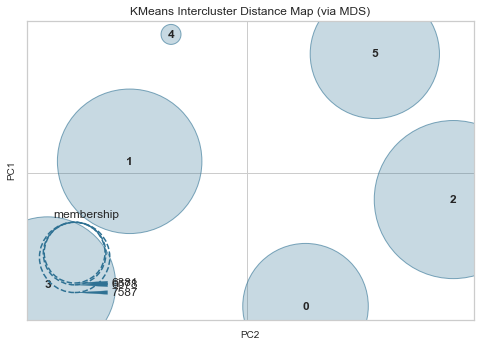

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [34]:
# Visualizing the clusters sizes and distances in 2D
visualizer = InterclusterDistance(kmeans)
visualizer.fit(X_pca_reduced)
visualizer.show()

Circles represent the clusters (0 to 5). Even at two dimensions it is possible to see that although the two components only represent around 26% of the variance, some distance between clusters seems to exist.

In [ ]:
# Create a dataframe with the weights per component
wheightsDF = pd.DataFrame(pca.components_,columns=X.columns)
wheightsDF

,default_no,default_unknown,default_yes,housing_no,housing_yes,housing_unknown,loan_no,loan_yes,loan_unknown,poutcome_nonexistent,...,job_admin.,job_blue-collar,job_technician,job_Other,marital_married,marital_single,marital_Other,education_high.school,education_university.degree,education_Other
0,-0.263703,2.636227e-01,8.082138e-05,0.065276,-0.066780,0.001504,0.011995,-0.013499,0.001504,0.052917,...,-0.281940,0.285499,-0.000656,-0.002903,0.356974,-0.328934,-0.028040,-0.146866,-0.332990,0.479856
1,0.014083,-1.411862e-02,3.569667e-05,0.701199,-0.702042,0.000843,0.047450,-0.048293,0.000843,0.014771,...,0.028594,-0.027613,-0.011615,0.010634,-0.029543,0.024236,0.005307,0.032374,0.030894,-0.063269
2,0.052819,-5.278139e-02,-3.774934e-05,0.015163,-0.015901,0.000737,0.004060,-0.004798,0.000737,-0.001844,...,-0.063562,0.311711,0.166722,-0.414871,-0.390427,0.385467,0.004960,-0.176385,-0.226200,0.402586
3,-0.132356,1.323615e-01,-5.654380e-06,-0.004906,0.003325,0.001581,0.018801,-0.020382,0.001581,-0.034197,...,-0.230255,-0.076117,-0.070939,0.377310,-0.455762,0.344545,0.111217,0.162021,-0.209130,0.047109
4,-0.391866,3.918668e-01,-4.113527e-07,-0.006077,0.003884,0.002193,-0.044648,0.042455,0.002193,0.122544,...,0.427100,0.084817,-0.036818,-0.475099,-0.111010,0.083499,0.027510,-0.063100,0.226979,-0.163879
5,-0.464569,4.645715e-01,-2.126449e-06,-0.014870,0.012220,0.002649,-0.006017,0.003368,0.002649,0.094042,...,-0.121231,-0.045790,-0.090523,0.257544,-0.051582,0.096447,-0.044865,0.158772,-0.023583,-0.135188
6,0.023484,-2.342245e-02,-6.191278e-05,0.018992,-0.078503,0.059511,-0.729411,0.669899,0.059511,-0.007502,...,-0.023813,0.005534,-0.017617,0.035896,0.001012,0.003693,-0.004705,0.012669,-0.033192,0.020523
7,0.054848,-5.490080e-02,5.276311e-05,-0.011390,0.013798,-0.002409,0.010872,-0.008463,-0.002409,-0.005823,...,0.168820,0.138195,-0.104670,-0.202345,0.096516,-0.063506,-0.033010,0.711520,-0.544242,-0.167278
8,-0.055977,5.604375e-02,-6.652797e-05,0.013067,-0.013211,0.000144,0.009925,-0.010069,0.000144,-0.493190,...,0.219783,0.122811,-0.218693,-0.123901,0.088106,-0.019814,-0.068292,0.000593,-0.024920,0.024327
9,-0.120039,1.198677e-01,1.717583e-04,0.005993,-0.008904,0.002911,-0.006521,0.003610,0.002911,-0.511061,...,-0.094388,0.039485,-0.046586,0.101489,-0.014007,0.045310,-0.031303,-0.072407,0.094281,-0.021874


In [ ]:
# Study the weights of component 15
comp = abs(wheightsDF.iloc[14])  ## index 14 is component 15
comp = comp.sort_values(ascending=False)
comp

age_bins_20-29                 0.555727
y                              0.508653
age_bins_50-59                 0.364155
marital_single                 0.319757
marital_Other                  0.310479
age_bins_40-49                 0.184295
poutcome_failure               0.129981
poutcome_success               0.121932
job_blue-collar                0.119980
education_high.school          0.081874
job_admin.                     0.072328
education_Other                0.064399
default_no                     0.037842
default_unknown                0.037768
job_Other                      0.029656
job_technician                 0.017996
education_university.degree    0.017475
age_bins_30-39                 0.013768
age_bins_>=60                  0.013675
marital_married                0.009277
poutcome_nonexistent           0.008049
age_bins_<20                   0.007184
housing_no                     0.003713
loan_yes                       0.003356
loan_unknown                   0.002016


### Interpret clusters results


In [ ]:
# Check the mean values of each cluster for top 30 relevant features
top_features = comp[:30].index
clustersMeanDF = pd.DataFrame(X_beforeNorm[top_features].groupby(y_kmeans).mean(),columns=top_features)
clustersMeanDF.transpose()

,0,1,2,3,4,5
age_bins_20-29,0.126783,0.129959,0.171815,0.056658,0.203562,0.137732
y,0.108604,0.126400,0.132750,0.049379,0.114724,0.139708
age_bins_50-59,0.162044,0.172005,0.117988,0.289568,0.109132,0.141076
marital_single,0.218618,0.241334,0.375312,0.119737,0.354525,0.377926
marital_Other,0.113775,0.119810,0.125596,0.081205,0.132947,0.112496
age_bins_40-49,0.259520,0.255832,0.213037,0.380619,0.221371,0.200213
poutcome_failure,0.104999,0.117833,0.105383,0.054945,0.134811,0.110064
poutcome_success,0.031343,0.040728,0.040768,0.006279,0.033547,0.045455
job_blue-collar,0.396803,0.367075,0.040768,0.445412,0.085939,0.006385
education_high.school,0.000000,0.000000,0.432887,0.124732,1.000000,0.000000


#### Some insights:

**Cluster 0**: Less educated, with family, and lower income
* Less educated customers (no high-school or university degree)
* Blue-collar, technicians, and other jobs
* 98% do not own a house
* Customers above the 30 years old, being the second group with oldest Customers
* 67% are married

**Cluster 1**: Less educated, with family, with higher income
* Less educated customers (no high-school or university degree)
* Blue-collar, technicians, and other jobs
* 97% own a house
* Customers above the 30 years old, being the first group with oldest Customers
* 64% are married
* More likely to have a loan than customers of cluster 0 (probably for the house)

**Cluster 2**: Better educated, but not owning a house
* Customers from 20-59, but with almost half having 30-39 years hold
* Have an high-school diploma or a university degree
* Do not own a house
* 50% are married
* More than 40 have administrative jobs
* Second cluster more propensive to direct markeitng

**Cluster 3**: Direct marketing sceptics
* Majority of the customers above 40 years old
* Less likely to subscribe
* No record of default
* 80% are married
* Different levels of education

**Cluster 4**: Younger customers with some acquisitive power
* Majority of customers below 50 years old, with 20% having less than 30 years old
* Customers without a university degree
* 96% own a house
* No record of default
* Have administrative or other jobs
* Half are married

**Cluster 5**: Customers with high acquisitive power 
* First cluster more propensive to direct marketing
* 70% of the customers have between 30 and 49 years old
* All have a university degree
* Most likely to have an administrative or a technician job
* Half are married
* 96% own a house
* No record of default

### **EXERCISE 1**
Based on previous findings what products could the bank market to different clusters?

### **EXERCISE 2**
Save this notebook with another name. Then, open that copy and redo the customer segmentation without the PCA dimension reduction techniques. Delete and adapt all the necessary code. After, compare the two notebooks to see the differences.